In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import random
%matplotlib inline
print "Done"

Done


In [2]:
def display_images_at_random(dataset, labels):
    # random.seed(1)
    
    f, axarr = plt.subplots(3, 3, figsize=(10,10))
    
    for i in range(3):
        for j in range(3):
            img_rand_index = random.randrange(0,dataset.shape[0])
            img  = dataset[img_rand_index]
            axarr[i, j].imshow(img.reshape(img.shape[0],img.shape[1]), cmap=plt.cm.Greys);
            axarr[i, j].set_title('Label: ' + str(labels[img_rand_index]) + " ID: " + str(img_rand_index))

    plt.show()

In [3]:
train_dataset = np.load("train_dataset.npy")
train_labels = np.load("train_labels.npy")
train_dataset_n_digits = np.load("train_n_bboxes.npy")
print('Training set', train_dataset.shape, train_labels.shape, train_dataset_n_digits.shape)

('Training set', (235000, 56, 56, 1), (235000, 5), (235000,))


Display some of the images just to make sure everything is fine

In [4]:
BATCH_SIZE=64
IMAGE_SIZE=56
N_CHANNELS=1
NUM_LABELS=10
NUM_DIGITS=5
LEARNING_RATE_DECAY_FACTOR = 0.1  # Learning rate decay factor.
INITIAL_LEARNING_RATE = 0.1       # Initial learning rate.

([<matplotlib.axis.XTick at 0x7f7c691b1ed0>,
 <a list of 6 Text xticklabel objects>)

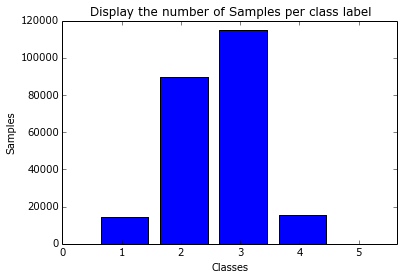

In [5]:
# distribution of sequences with 1,2,3,4 digits
data_distribution = np.bincount(train_dataset_n_digits)
index = np.arange(6)
plt.bar(index, data_distribution)
plt.title("Display the number of Samples per class label")
plt.xlabel('Classes')
plt.ylabel('Samples')

bar_width = 0.35
plt.xticks(index + bar_width, ('0', '1', '2', '3', '4', '5'))

In [6]:
print data_distribution
train_dataset_d1 = np.zeros(shape=(data_distribution[1], train_dataset.shape[1], train_dataset.shape[2], N_CHANNELS), dtype=np.float32)
train_dataset_d2 = np.zeros(shape=(data_distribution[2], train_dataset.shape[1], train_dataset.shape[2], N_CHANNELS), dtype=np.float32)
train_dataset_d3 = np.zeros(shape=(data_distribution[3], train_dataset.shape[1], train_dataset.shape[2], N_CHANNELS), dtype=np.float32)
train_dataset_d4 = np.zeros(shape=(data_distribution[4], train_dataset.shape[1], train_dataset.shape[2], N_CHANNELS), dtype=np.float32)

train_labels_d1 = np.zeros(shape=(data_distribution[1], NUM_DIGITS), dtype=np.float32)
train_labels_d2 = np.zeros(shape=(data_distribution[2], NUM_DIGITS), dtype=np.float32)
train_labels_d3 = np.zeros(shape=(data_distribution[3], NUM_DIGITS), dtype=np.float32)
train_labels_d4 = np.zeros(shape=(data_distribution[4], NUM_DIGITS), dtype=np.float32)

index_d1 = 0
index_d2 = 0
index_d3 = 0
index_d4 = 0

for bbox_index in range(0,len(train_dataset_n_digits)):
    bbox = train_dataset_n_digits[bbox_index]
    if bbox == 1:
        train_dataset_d1[index_d1,:,:,:] = train_dataset[bbox_index,:,:,:]
        train_labels_d1[index_d1,:] = train_labels[bbox_index,:]
        index_d1 += 1
    elif bbox == 2:
        train_dataset_d2[index_d2,:,:,:] = train_dataset[bbox_index,:,:,:]
        train_labels_d2[index_d2,:] = train_labels[bbox_index,:]
        index_d2 += 1
    elif bbox == 3:
        train_dataset_d3[index_d3,:,:,:] = train_dataset[bbox_index,:,:,:]
        train_labels_d3[index_d3,:] = train_labels[bbox_index,:]
        index_d3 += 1
    elif bbox == 4:
        train_dataset_d4[index_d4,:,:,:] = train_dataset[bbox_index,:,:,:]
        train_labels_d4[index_d4,:] = train_labels[bbox_index,:]
        index_d4 += 1

[     0  14486  89598 115062  15730    124]


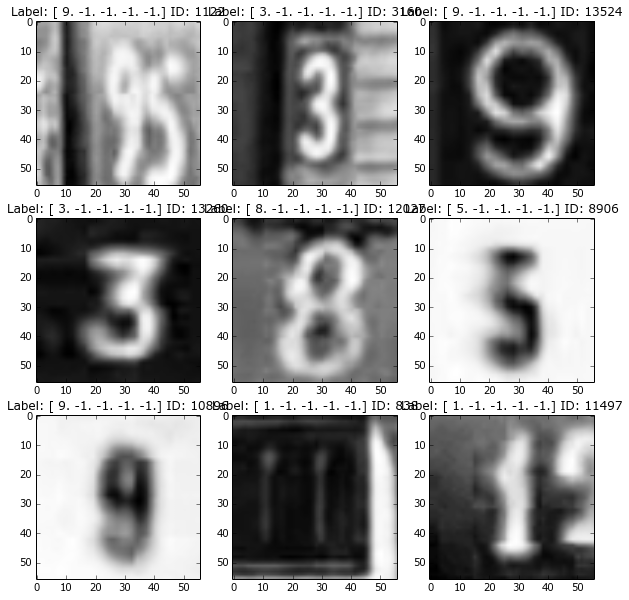

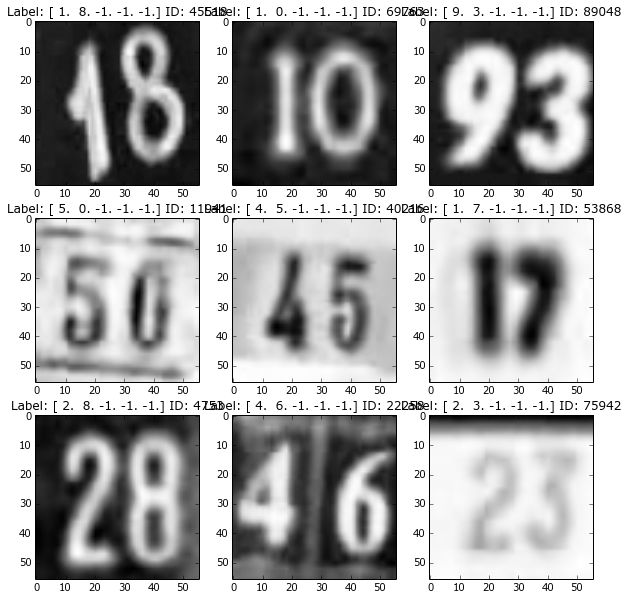

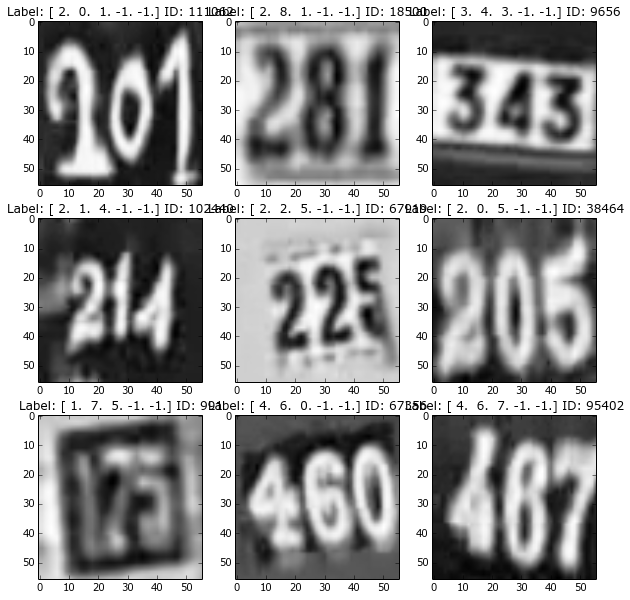

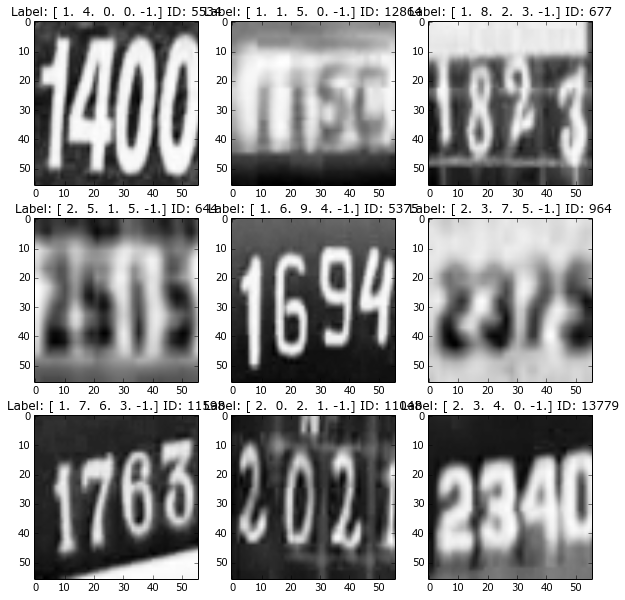

In [7]:
display_images_at_random(train_dataset_d1, train_labels_d1)
display_images_at_random(train_dataset_d2, train_labels_d2)
display_images_at_random(train_dataset_d3, train_labels_d3)
display_images_at_random(train_dataset_d4, train_labels_d4)

Compute the digit distribution for the first digit in each training image.

[  621 65395 45669 31826 24761 19376 14416 13802 10080  9054]
('Total dataset size:', 235000)


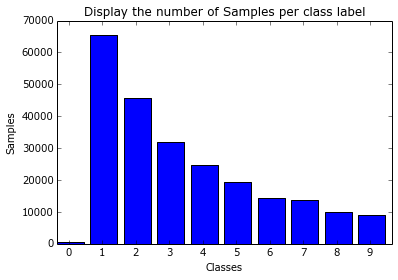

In [8]:
batch_d1 = []
NUM_CLASSES=10
which_digit = 0
add_error_class = False
for digit in train_labels:
    if digit[which_digit] == -1:
        batch_d1.append(10)
        add_error_class = True
    else:
        batch_d1.append(digit[which_digit])
 
if add_error_class:
    NUM_CLASSES+=1

data_distribution = np.bincount(batch_d1)
print data_distribution
index = np.arange(NUM_CLASSES)
plt.bar(index, data_distribution)
plt.title("Display the number of Samples per class label")
plt.xlabel('Classes')
plt.ylabel('Samples')

bar_width = 0.35
plt.xticks(index + bar_width, ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))

print ("Total dataset size:", np.sum(data_distribution))
plt.show()

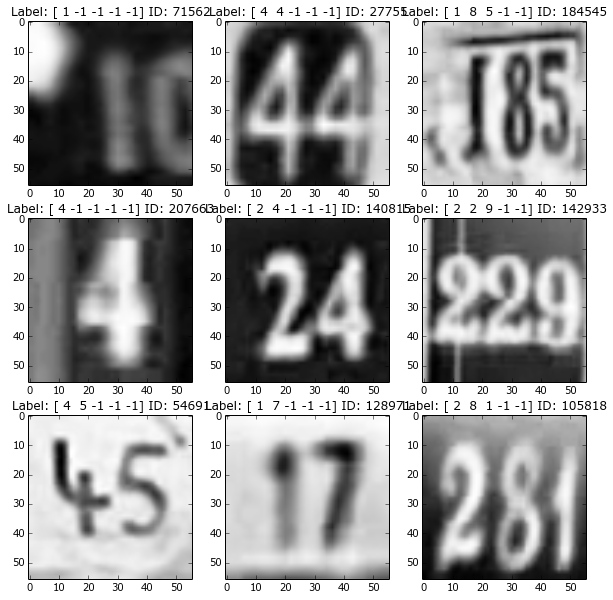

In [9]:
display_images_at_random(train_dataset, train_labels)

In [10]:
def reformat(train_labels):
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    index = 0
    train_labels_one_hot = np.zeros(shape=(train_labels.shape[0], 5, 10), dtype=np.float32)
    for labels in train_labels:
        for l in labels:
            one_hot_array = (np.arange(NUM_LABELS) == labels[:,None]).astype(np.float32)
        train_labels_one_hot[index] = one_hot_array
        index += 1

    return train_labels_one_hot

# train_labels = reformat(train_labels)
train_labels_d1 = reformat(train_labels_d1)
train_labels_d2 = reformat(train_labels_d2)
train_labels_d3 = reformat(train_labels_d3)
train_labels_d4 = reformat(train_labels_d4)

In [11]:
print('Train set', train_dataset.shape, train_labels.shape)
print('Train set (D1)', train_dataset_d1.shape, train_labels_d2.shape)
print('Train set (D2)', train_dataset_d2.shape, train_labels_d2.shape)
print('Train set (D3)', train_dataset_d3.shape, train_labels_d3.shape)
print('Train set (D4)', train_dataset_d4.shape, train_labels_d4.shape)

('Train set', (235000, 56, 56, 1), (235000, 5))
('Train set (D1)', (14486, 56, 56, 1), (89598, 5, 10))
('Train set (D2)', (89598, 56, 56, 1), (89598, 5, 10))
('Train set (D3)', (115062, 56, 56, 1), (115062, 5, 10))
('Train set (D4)', (15730, 56, 56, 1), (15730, 5, 10))


In [12]:
def reformat_N_digits(n_digits):
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  n_digits = (np.arange(NUM_DIGITS) == n_digits[:,None]).astype(np.float32)
  return n_digits

In [13]:
train_dataset_n_digits = np.array(train_dataset_n_digits)
train_dataset_n_digits = reformat_N_digits(train_dataset_n_digits)

In [14]:
print train_dataset_n_digits.shape

(235000, 5)


[ 7  1 -1 -1 -1]
[ 1  3  9 -1 -1]


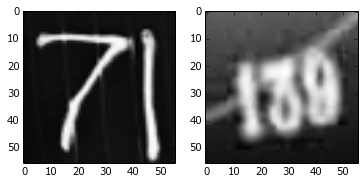

In [15]:
_, (ax1, ax2) = plt.subplots(1, 2)

id = 33402
img = train_dataset[id,:,:]
ax1.imshow(img.reshape(img.shape[0],img.shape[1]), cmap=plt.cm.Greys);
print train_labels[id]

id = 34662
img = train_dataset[id,:,:]
ax2.imshow(img.reshape(img.shape[0],img.shape[1]), cmap=plt.cm.Greys);
print train_labels[id]

In [16]:
VALIDATION_DATASET_SIZE=5000
TEST_DATASET_SIZE=20000

valid_dataset_d1 = train_dataset_d1[0:VALIDATION_DATASET_SIZE]
valid_dataset_d2 = train_dataset_d2[0:VALIDATION_DATASET_SIZE]
valid_dataset_d3 = train_dataset_d3[0:VALIDATION_DATASET_SIZE]
valid_dataset_d4 = train_dataset_d4[0:VALIDATION_DATASET_SIZE]

valid_labels_d1 = train_labels_d1[0:VALIDATION_DATASET_SIZE]
valid_labels_d2 = train_labels_d2[0:VALIDATION_DATASET_SIZE]
valid_labels_d3 = train_labels_d3[0:VALIDATION_DATASET_SIZE]
valid_labels_d4 = train_labels_d4[0:VALIDATION_DATASET_SIZE]

train_dataset_d1 = train_dataset_d1[VALIDATION_DATASET_SIZE:]
train_dataset_d2 = train_dataset_d2[VALIDATION_DATASET_SIZE:]
train_dataset_d3 = train_dataset_d3[VALIDATION_DATASET_SIZE:]
train_dataset_d4 = train_dataset_d4[VALIDATION_DATASET_SIZE:]

train_labels_d1 = train_labels_d1[VALIDATION_DATASET_SIZE:]
train_labels_d2 = train_labels_d2[VALIDATION_DATASET_SIZE:]
train_labels_d3 = train_labels_d3[VALIDATION_DATASET_SIZE:]
train_labels_d4 = train_labels_d4[VALIDATION_DATASET_SIZE:]

In [17]:
print('Training set (d1)', train_dataset_d1.shape, train_labels_d1.shape)
print('Training set (d2)', train_dataset_d2.shape, train_labels_d2.shape)
print('Training set (d3)', train_dataset_d3.shape, train_labels_d3.shape)
print('Training set (d4)', train_dataset_d4.shape, train_labels_d4.shape)

print('Validation set (d1)', valid_dataset_d1.shape, valid_labels_d1.shape)
print('Validation set (d2)', valid_dataset_d2.shape, valid_labels_d2.shape)
print('Validation set (d3)', valid_dataset_d3.shape, valid_labels_d3.shape)
print('Validation set (d4)', valid_dataset_d4.shape, valid_labels_d4.shape)
# print('Test set', test_dataset.shape, test_labels.shape)

('Training set (d1)', (9486, 56, 56, 1), (9486, 5, 10))
('Training set (d2)', (84598, 56, 56, 1), (84598, 5, 10))
('Training set (d3)', (110062, 56, 56, 1), (110062, 5, 10))
('Training set (d4)', (10730, 56, 56, 1), (10730, 5, 10))
('Validation set (d1)', (5000, 56, 56, 1), (5000, 5, 10))
('Validation set (d2)', (5000, 56, 56, 1), (5000, 5, 10))
('Validation set (d3)', (5000, 56, 56, 1), (5000, 5, 10))
('Validation set (d4)', (5000, 56, 56, 1), (5000, 5, 10))


In [18]:
x = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS], name="train_dataset_planceholder")

# n_digits_labels = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_DIGITS], name="train_n_digits_labels_planceholder")

y_ = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_LABELS], name="train_labels_d1_placeholder")
y_d2_ = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_LABELS], name="train_labels_d2_placeholder")
y_d3_ = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_LABELS], name="train_labels_d3_placeholder")
# y_d4_ = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_LABELS], name="train_labels_d4_placeholder")

tf_valid_dataset = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS], name="valid_dataset_d1_placeholder")

d1 = tf.constant(True)
d2 = tf.placeholder(tf.bool, name="is_2_digit_image_placeholder")
d3 = tf.placeholder(tf.bool, name="is_3_digit_image_placeholder")
flag = tf.constant(True)
# d2 = tf.placeholder(tf.bool, name="d2_flag")

# tf_valid_dataset = tf.constant(valid_dataset_d1, name="validation_dataset")
# tf_valid_dataset = tf.cast(tf_valid_dataset, tf.float32)

# tf_test_dataset = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS], name="test_dataset_placeholder")
# tf_test_dataset = tf.cast(tf_test_dataset, tf.float32)

In [19]:
def weight_variable(shape, stddev=1e-1):
  initial = tf.truncated_normal(shape, stddev=stddev)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(value=0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x, strides=[1, 2, 2, 1]):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=strides, padding='SAME')

# randomly crop and flip the image
def distort_inputs(image):
    distorted_image = tf.random_crop(image, [56, 56, 1])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    return distorted_image

print "Done"

Done


In [20]:
CONV1_DEPTH=16
W_conv1 = weight_variable([5, 5, N_CHANNELS, CONV1_DEPTH], stddev=0.1)
b_conv1 = bias_variable([CONV1_DEPTH])

CONV2_DEPTH=32
W_conv2 = weight_variable([5, 5, CONV1_DEPTH, CONV2_DEPTH], stddev=0.1)
b_conv2 = bias_variable([CONV2_DEPTH])

CONV3_DEPTH=48
W_conv3 = weight_variable([5, 5, CONV2_DEPTH, CONV3_DEPTH], stddev=0.09)
b_conv3 = bias_variable([CONV3_DEPTH])

CONV4_DEPTH=64
W_conv4 = weight_variable([5, 5, CONV3_DEPTH, CONV4_DEPTH], stddev=0.08)
b_conv4 = bias_variable([CONV4_DEPTH])

# CONV5_DEPTH=80
# W_conv5 = weight_variable([5, 5, CONV4_DEPTH, CONV5_DEPTH], stddev=0.07)
# b_conv5 = bias_variable([CONV5_DEPTH])

# CONV6_DEPTH=96
# W_conv6 = weight_variable([5, 5, CONV5_DEPTH, CONV6_DEPTH], stddev=0.06)
# b_conv6 = bias_variable([CONV6_DEPTH])

FC1_SIZE = 384
W_fc1 = weight_variable([4 * 4 * CONV4_DEPTH, FC1_SIZE], stddev=0.1)
b_fc1 = bias_variable([FC1_SIZE])

FC2_SIZE = 384
W_fc2 = weight_variable([FC1_SIZE, FC2_SIZE], stddev=0.1)
b_fc2 = bias_variable([FC2_SIZE])

FC3_SIZE = 1024
W_fc3 = weight_variable([FC2_SIZE, FC3_SIZE], stddev=0.03)
b_fc3 = bias_variable([FC3_SIZE])

read_output_layer = weight_variable([FC3_SIZE, NUM_LABELS])
read_output_bias = bias_variable([NUM_LABELS])

read_output_layer_digit_2 = weight_variable([FC3_SIZE, NUM_LABELS])
read_output_bias_digit_2 = bias_variable([NUM_LABELS])

read_output_layer_digit_3 = weight_variable([FC3_SIZE, NUM_LABELS])
read_output_bias_digit_3 = bias_variable([NUM_LABELS])

read_output_layer_digit_4 = weight_variable([FC3_SIZE, NUM_LABELS])
read_output_bias_digit_4 = bias_variable([NUM_LABELS])

print "Done"

Done


In [21]:
def model(x_image, training=False):    
    
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    norm1 = tf.nn.lrn(h_pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')
    
    h_conv2 = tf.nn.relu(conv2d(norm1, W_conv2) + b_conv2)
    norm2 = tf.nn.lrn(h_conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    h_pool2 = max_pool_2x2(norm2)
    
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    norm3 = tf.nn.lrn(h_pool3, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm3')    
    
    h_conv4 = tf.nn.relu(conv2d(norm3, W_conv4) + b_conv4)
    norm4 = tf.nn.lrn(h_conv4, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm4')    
    h_pool4 = max_pool_2x2(norm4) 

    # h_conv5 = tf.nn.relu(conv2d(h_pool4, W_conv5) + b_conv5)
    # h_pool5 = max_pool_2x2(h_conv5, strides=[1,1,1,1])    
    # norm5 = tf.nn.lrn(h_pool5, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm5')    

    # h_conv6 = tf.nn.relu(conv2d(norm5, W_conv6) + b_conv6)
    # norm6 = tf.nn.lrn(h_conv6, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm6')    
    # h_pool6 = max_pool_2x2(norm6)    
    
    shape = h_pool4.get_shape().as_list()  
    h_pool4_flat = tf.reshape(h_pool4, [-1, shape[1] * shape[2] * shape[3]])
    
    # First fully connected layer
    h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat, W_fc1) + b_fc1)
    if (training == True):
        h_fc1 = tf.nn.dropout(h_fc1, 0.5)
        
    # Second fully connected layer
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
    if (training == True):
        h_fc2 = tf.nn.dropout(h_fc2, 0.5)
       
    # Third fully connected layer
    h_fc3 = tf.nn.relu(tf.matmul(h_fc2, W_fc3) + b_fc3)
    if (training == True):
        h_fc3 = tf.nn.dropout(h_fc3, 0.5)
    
    result = []
    
    # digit #1
    digit_1 = tf.matmul(h_fc3, read_output_layer) + read_output_bias
    
    blank_digit = lambda: tf.zeros(shape=[64,10], dtype=tf.float32, name="Blank_digit")
    
    # digit #2
    f2 = lambda: (tf.matmul(h_fc3, read_output_layer_digit_2) + read_output_bias_digit_2)
    digit_2 = tf.case([(d2, f2)], default=blank_digit)
    
    # digit #3
    f3 = lambda: tf.matmul(h_fc3, read_output_layer_digit_3) + read_output_bias_digit_3
    digit_3 = tf.case([(d3, f3)], default=blank_digit)
    
    return digit_1, digit_2, digit_3

print "Done"

Done


In [22]:
# logits = model(x, True)
logits, logits_d2, logits_d3 = model(x, True)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y_))
loss_d2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_d2, y_d2_))
loss_d3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_d3, y_d3_))

# loss_n_digits = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_n_digits, n_digits_labels))

# apply L2 regularization of the trained weights
# L2 regularization for the fully connected parameters.
# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(b_fc1) +
                tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(b_fc2) + 
                tf.nn.l2_loss(W_fc3) + tf.nn.l2_loss(b_fc3))

# Add the regularization term to the loss.
loss += 5e-4 * regularizers
loss_d2 += 5e-4 * regularizers
loss_d3 += 5e-4 * regularizers

loss_summary = tf.scalar_summary('loss digit 1', loss)
# tf.scalar_summary('loss digit 2', loss_d2)
# tf.scalar_summary('loss digit 3', loss_d3)

# Create a variable to track the global step.
global_step = tf.Variable(0, name='global_step', trainable=False)
starter_learning_rate = 0.003
learning_rate = tf.train.exponential_decay(starter_learning_rate, 
                                           global_step * BATCH_SIZE,
                                           train_labels.shape[0] / 8, 
                                           0.99, 
                                           staircase=True)

learning_rate_summary = tf.scalar_summary('learning_rate', learning_rate)

# optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

momentum = 0.9
# opt_n_digits = tf.train.MomentumOptimizer(learning_rate, momentum, use_locking=False, name='Momentum_n_digits').minimize(loss_n_digits, global_step=global_step)
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_locking=False, name='Momentum_digit_1').minimize(loss, global_step=global_step)
optimizer_d2 = tf.train.MomentumOptimizer(learning_rate, momentum, use_locking=False, name='Momentum_digit_2').minimize(loss_d2, global_step=global_step)
optimizer_d3 = tf.train.MomentumOptimizer(learning_rate, momentum, use_locking=False, name='Momentum_digit_3').minimize(loss_d3, global_step=global_step)

# Predictions for the minibatch, validation set and test set.
train_prediction = tf.nn.softmax(logits)
train_d2_prediction = tf.nn.softmax(logits_d2)
train_d3_prediction = tf.nn.softmax(logits_d3)

# train_n_digits_prediction = tf.nn.softmax(logits_n_digits)

# valid_logits = model(tf_valid_dataset, False)
# valid_logits, valid_logits_n_digits = model(tf_valid_dataset, False)
valid_logits, valid_logits_d2, valid_logits_d3 = model(tf_valid_dataset, False)
valid_prediction = tf.nn.softmax(valid_logits)
valid_prediction_d2 = tf.nn.softmax(valid_logits_d2)
valid_prediction_d3 = tf.nn.softmax(valid_logits_d3)

# valid_n_digits_prediction = tf.nn.softmax(valid_logits_n_digits)

# test_logits = model(tf_test_dataset, False)
# test_prediction = tf.nn.softmax(test_logits)

print "Done"

Done


In [23]:
# Create a new interactive session that we'll use in
# subsequent code cells.
s = tf.InteractiveSession()

# Use our newly created session as the default for 
# subsequent operations.
s.as_default()

# Merge all the summaries and write them out to /tmp/mnist_logs (by default)
merged = tf.merge_summary([loss_summary, learning_rate_summary])
train_writer = tf.train.SummaryWriter('./summary', s.graph)

# Initialize all the variables we defined above.
init = tf.initialize_all_variables()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

s.run(init)

In [24]:
def error_rate(predictions, labels):
  """Return the error rate and confusions."""
  correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
  total = predictions.shape[0]

  error = 100.0 - (100 * float(correct) / float(total))

  confusions = np.zeros([10, 10], np.float32)
  bundled = zip(np.argmax(predictions, 1), np.argmax(labels, 1))
  for predicted, actual in bundled:
    confusions[predicted, actual] += 1
    
  return error, confusions

print 'Done'

Done


In [25]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [26]:
def compute_per_digit_accuracy(predictions, labels, for_digit):
    index = 0
    batch = np.zeros(shape=(labels.shape[0],10), dtype=np.float32)
    for digit in labels:
        # print digit.shape
        batch[index] = digit[for_digit] # get s only the first digits of each image
        index += 1
        
    return accuracy(predictions, batch)

In [27]:
def get_error_rate(predictions, labels):
    index = 0
    batch_d1 = np.zeros(shape=(labels.shape[0],10), dtype=np.float32)
    for digit in labels:
        # print digit.shape
        batch_d1[index] = digit[0] # get s only the first digits of each image
        index += 1
        
    return error_rate(predictions, batch_d1)

In [28]:
def get_batch_data_and_labels(global_step, batch_size, train_data, train_labels):
    offset = (global_step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_data[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    return batch_data, batch_labels

In [29]:
total_steps = 10000
switcher = False
for step in xrange(total_steps):
    
    batch_d1 = np.zeros(shape=(BATCH_SIZE,10), dtype=np.float32)
    batch_d2 = np.zeros(shape=(BATCH_SIZE,10), dtype=np.float32)
    batch_d3 = np.zeros(shape=(BATCH_SIZE,10), dtype=np.float32)

    for current_batch_digit in range(1,4):
        
        if current_batch_digit == 1:
            batch_data_d1, batch_labels_d1 = get_batch_data_and_labels(step, BATCH_SIZE, train_dataset_d1, train_labels_d1)

            # gets only the digits #1 labels data
            index = 0
            for digit in batch_labels_d1[:,]:
                batch_d1[index] = digit[0]
                index += 1
            # print batch_data_d1.shape
            feed_dict = {x : batch_data_d1, y_ : batch_d1, d2: False, d3: False}

            # Run the graph and fetch some of the nodes.feed_dict=feed_dict)
            summary, _, l_d1, predictions, lr, gl = s.run([merged, optimizer, loss, train_prediction, learning_rate, global_step], feed_dict=feed_dict)
            train_writer.add_summary(summary, step)
            
        elif current_batch_digit == 2:
            batch_data_d2, batch_labels_d2 = get_batch_data_and_labels(step, BATCH_SIZE, train_dataset_d2, train_labels_d2)
        
            index = 0
            for digit in batch_labels_d2[:,]:
                batch_d1[index] = digit[0]
                batch_d2[index] = digit[1]
                index += 1
            
            # print batch_data_d1.shape
            feed_dict = {x : batch_data_d2, y_ : batch_d1, y_d2_ : batch_d2, d2: True, d3: False}
        
            # Run the graph and fetch some of the nodes.
            _, _, l_d1, l_d2, predictions, predictions_d2, lr, gl = s.run([optimizer, optimizer_d2, loss, loss_d2, 
                                                                           train_prediction, train_d2_prediction, 
                                                                           learning_rate, global_step], feed_dict=feed_dict)
           
        elif current_batch_digit == 3:
            batch_data_d3, batch_labels_d3 = get_batch_data_and_labels(step, BATCH_SIZE, train_dataset_d3, train_labels_d3)
        
            index = 0
            for digit in batch_labels_d3[:,]:
                batch_d1[index] = digit[0]
                batch_d2[index] = digit[1]
                batch_d3[index] = digit[2]
                index += 1
            
            # print batch_data_d1.shape
            feed_dict = {x : batch_data_d3, y_ : batch_d1, y_d2_ : batch_d2, y_d3_ : batch_d3, d2: True, d3: True}
        
            # Run the graph and fetch some of the nodes.
            _, _, _, l_d1, l_d2, l_d3, predictions, predictions_d2, predictions_d3, lr, gl = s.run([optimizer, optimizer_d2, optimizer_d3, 
                                                                              loss, loss_d2, loss_d3, train_prediction, 
                                                                              train_d2_prediction, train_d3_prediction,
                                                                              learning_rate, global_step], feed_dict=feed_dict)
                                                 
        
        
        if step % 100 == 0 and current_batch_digit == 3:
            print('Digit 1: Minibatch loss at step %d: %f\tLearning rate:%f' % (gl, l_d1, lr))
            print('Digit 1: Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_d1))
            if step % 300  == 0:
                print('Digit 1: Validation accuracy: %.1f%%' % compute_per_digit_accuracy(valid_prediction.eval({tf_valid_dataset: valid_dataset_d1, d2: False, d3: False}), valid_labels_d1, 0))

            print"-------------------------------------------";
            print('Digit 2: Minibatch loss at step %d: %f\tLearning rate:%f' % (gl, l_d2, lr))
            print('Digit 2: Minibatch accuracy: %.1f%%' % accuracy(predictions_d2, batch_d2))
            if step % 300  == 0:
                 print('Digit 2: Validation accuracy: %.1f%%' % compute_per_digit_accuracy(valid_prediction_d2.eval({tf_valid_dataset: valid_dataset_d2, d2: True, d3: False}), valid_labels_d2, 1))

            print"-------------------------------------------";
            print('Digit 3: Minibatch loss at step %d: %f\tLearning rate:%f' % (gl, l_d3, lr))
            print('Digit 3: Minibatch accuracy: %.1f%%' % accuracy(predictions_d3, batch_d3))
            if step % 300  == 0:
                 print('Digit 3: Validation accuracy: %.1f%%' % compute_per_digit_accuracy(valid_prediction_d3.eval({tf_valid_dataset: valid_dataset_d3, d2: False, d3: True}), valid_labels_d3, 2))
   
                    
            # print('N Digits: Minibatch loss at step %d: %f\tLearning rate:%f' % (gl, loss_n_dts, lr))
            # print('N Digits: Minibatch accuracy: %.1f%%' % accuracy(n_digits_predictions, batch_n_digits_labels))
            # if step % 500 == 0:
            #     print('N Digits: Validation accuracy: %.1f%%' % accuracy(valid_n_digits_prediction.eval(), valid_n_digits))
            print "=================================================="
        
print "Done training"

Digit 1: Minibatch loss at step 6: 5.249623	Learning rate:0.003000
Digit 1: Minibatch accuracy: 9.4%
Digit 1: Validation accuracy: 13.1%
-------------------------------------------
Digit 2: Minibatch loss at step 6: 6.403461	Learning rate:0.003000
Digit 2: Minibatch accuracy: 9.4%
Digit 2: Validation accuracy: 9.4%
-------------------------------------------
Digit 3: Minibatch loss at step 6: 6.434785	Learning rate:0.003000
Digit 3: Minibatch accuracy: 9.4%
Digit 3: Validation accuracy: 10.4%
Digit 1: Minibatch loss at step 606: 3.016515	Learning rate:0.002970
Digit 1: Minibatch accuracy: 32.8%
-------------------------------------------
Digit 2: Minibatch loss at step 606: 3.415226	Learning rate:0.002970
Digit 2: Minibatch accuracy: 10.9%
-------------------------------------------
Digit 3: Minibatch loss at step 606: 3.387667	Learning rate:0.002970
Digit 3: Minibatch accuracy: 12.5%
Digit 1: Minibatch loss at step 1206: 3.016869	Learning rate:0.002940
Digit 1: Minibatch accuracy: 25.

KeyboardInterrupt: 

In [ ]:
from scipy import misc
PIXEL_DEPTH=255.0

# display the first and the last image and labels for the training dataset
img = misc.imread("./image_test3.jpg", flatten=True)

# get the new image size
img_h = img.shape[0]
img_w = img.shape[1]

# if the image is greater than IMAGE_SIZE, slowly resize it
# until it fits the size
if img_h > IMAGE_SIZE or img_w > IMAGE_SIZE:
    if img_w >= img_h:
        target_width = IMAGE_SIZE
        target_height = int(round((img_h * IMAGE_SIZE) / float(img_w)))
    else:
        target_height = IMAGE_SIZE
        target_width = int(round((img_w * IMAGE_SIZE) / float(img_h)))

    if (target_width < 10 or target_height < 10):
        print "--- Discarding image \tShape:",target_height, target_width, "---"
        skipped_images_count += 1


    img = misc.imresize(img,(target_height, target_width))
    is_resized = True

if is_resized == True:
    print "Resizing image\tNew shape:",target_height, target_width

# get the new image size
img_h = img.shape[0]
img_w = img.shape[1]
# put the image to the defined size
if img_h < IMAGE_SIZE:
    top_padding = (IMAGE_SIZE-img_h)/2
    bottom_padding = IMAGE_SIZE-img_h - top_padding
    img = np.pad(img, ((top_padding,bottom_padding),(0,0)), "constant")

if img_w < IMAGE_SIZE:
    top_padding = (IMAGE_SIZE-img_w)/2
    bottom_padding = IMAGE_SIZE-img_w - top_padding
    img = np.pad(img, ((0,0),(top_padding,bottom_padding)), "constant")

# TODO: normalize the image
img = (img - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
img = img.reshape(1,IMAGE_SIZE,IMAGE_SIZE,N_CHANNELS)
print img.shape
plt.imshow(img[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap=plt.cm.Greys)
print img.shape

In [ ]:
pred1 = valid_prediction.eval({tf_valid_dataset: img, d2: False, d3: False})
pred2 = valid_prediction_d2.eval({tf_valid_dataset: img, d2: True, d3: False})
pred3 = valid_prediction_d3.eval({tf_valid_dataset: img, d2: False, d3: True})

print np.argmax(pred1, 1)
print np.argmax(pred2, 1)
print np.argmax(pred3, 1)

In [ ]:
test_error, confusions = get_error_rate(test_prediction.eval({tf_test_dataset: test_dataset}), test_labels)
print 'Test error: %.1f%%' % test_error

In [ ]:
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(NUM_LABELS))
plt.yticks(np.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
  for j, count in enumerate(cas):
    if count > 0:
      xoff = .07 * len(str(count))
      plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')
print 'Done'

In [ ]:
import scipy.misc as misc
import numpy as np

IMAGE_SIZE=56
N_CHANNELS=1
MAX_NUMBER_OF_SEGMENTATIONS=8

img_file_name = "image_test3.jpg"

original = misc.imread(img_file_name)
img = misc.imread(img_file_name,flatten=True)
img = misc.imresize(img, (IMAGE_SIZE,IMAGE_SIZE), interp='bilinear', mode=None)
print img.shape

PIXEL_DEPTH=255

test_image = np.zeros(shape=(1, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS), dtype=np.float32)

# normilize it
img = (img - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH # normilize
test_image[0] = img.reshape(IMAGE_SIZE,IMAGE_SIZE,N_CHANNELS)

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img, cmap=plt.cm.Greys);
ax1.set_title('Transformed')

ax2.imshow(original, cmap=plt.cm.Greys);
ax2.set_title('Original')

In [32]:
prediction = test_prediction.eval({tf_test_dataset: test_image})

In [33]:
print prediction
print np.argmax(prediction, 1)

[[  1.74425550e-05   3.49438437e-06   9.56964910e-01   1.90533570e-03
    3.15620936e-03   2.64062226e-04   3.30781448e-03   1.30507206e-05
    3.33615690e-02   1.00600568e-03]]
[2]
